# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import numpy as np
import scanpy as sc
import scipy
import pandas as pd 

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/SC3pv3_GEX_Human_PBMC_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata.var_names_make_unique()
adata

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5140 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

# Preprocessing (Quarity check)

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

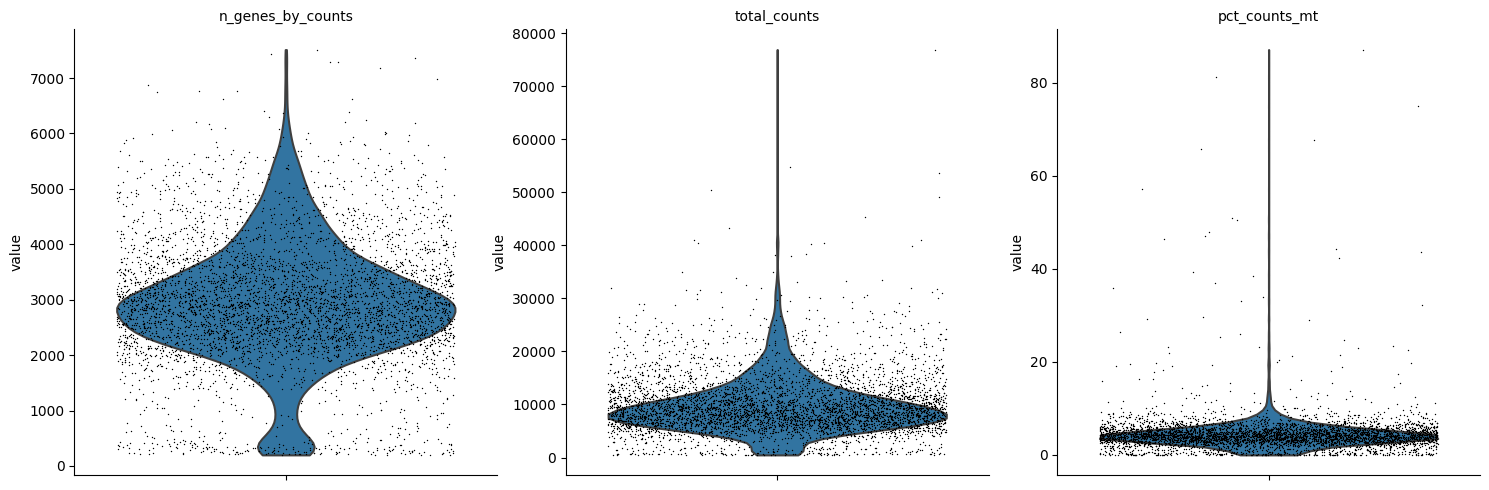

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

View of AnnData object with n_obs × n_vars = 4765 × 23729
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [7]:
adata_RECODE = adata.copy()
adata_RECODE

AnnData object with n_obs × n_vars = 4765 × 23729
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

RECODE

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 17915, '#non-significant genes': 5814, '#silent genes': 0, 'ell': 326, 'Elapsed time': '0h 0m 43s 505ms', 'solver': 'full', '#test_data': 953}


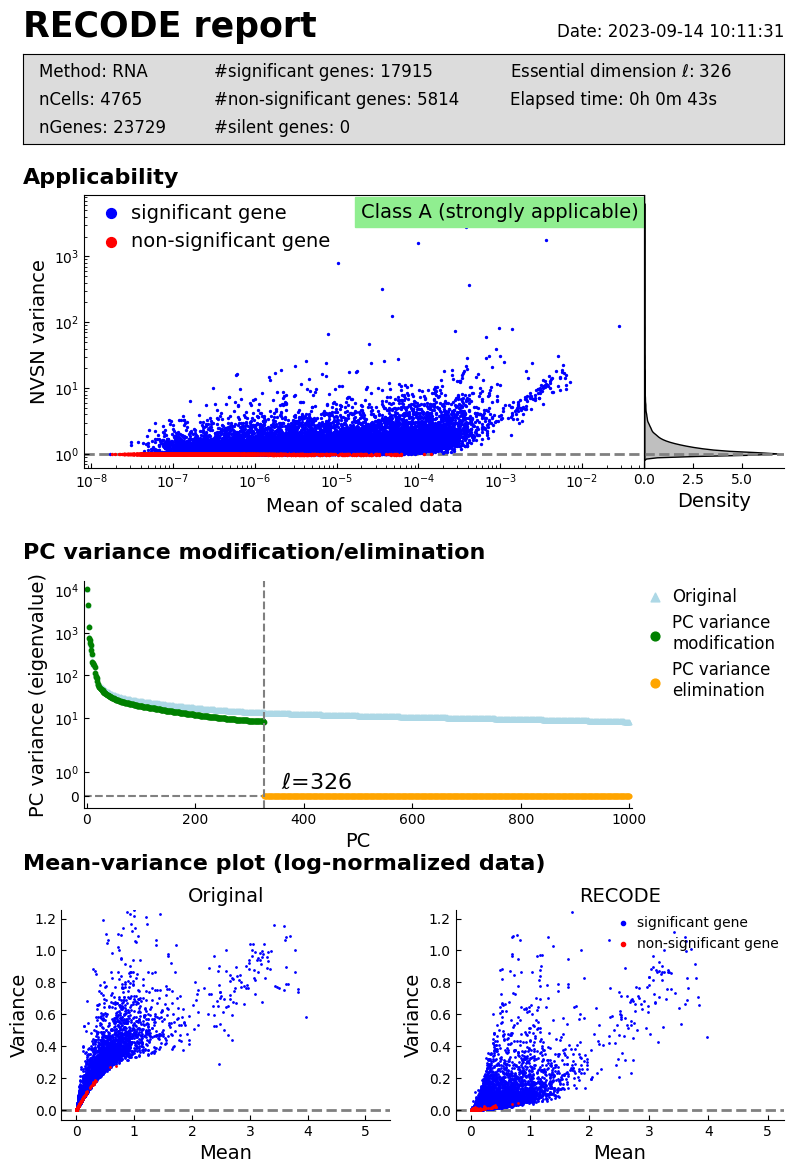

In [8]:
recode = screcode.RECODE(version=2)
adata_RECODE = recode.fit_transform(adata_RECODE)
recode.report()

# Downstream analysis by scanpy

In [9]:
if scipy.sparse.issparse(adata.X):
    adata.X = adata.X.toarray()
adata_RECODE.X = adata_RECODE.layers["RECODE"]

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.normalize_total(adata_RECODE, target_sum=1e4)
sc.pp.log1p(adata_RECODE)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


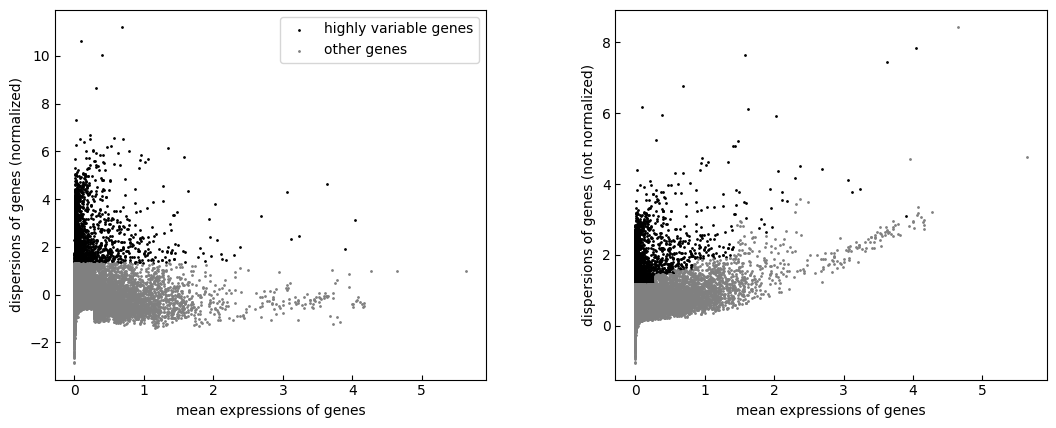

In [11]:
n_top_genes =2000
sc.pp.highly_variable_genes(adata, n_top_genes =2000)
sc.pl.highly_variable_genes(adata)
# adata = adata[:, adata.var.highly_variable]

In [12]:
idx_sort_ = np.argsort(adata_RECODE.var.normalized_variance_RECODE.values)[::-1][:n_top_genes]
adata_RECODE.var["highly_variable_RECODE"] = np.full(adata_RECODE.shape[1],False)
adata_RECODE.var["highly_variable_RECODE"][idx_sort_] = True
np.sort(adata_RECODE.var.normalized_variance_RECODE.values)[::-1][:n_top_genes]

C:\Users\expou\AppData\Local\Temp\ipykernel_19968\776989814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_RECODE.var["highly_variable_RECODE"][idx_sort_] = True


array([5.45584277e+03, 3.33711621e+03, 2.75856934e+03, ...,
       2.15557408e+00, 2.15546036e+00, 2.15528178e+00])

In [13]:
n_gene_intrsct = len(np.intersect1d(adata.var.index[adata.var.highly_variable],adata_RECODE.var.index[adata_RECODE.var["highly_variable_RECODE"]]))
n_gene_intrsct

787

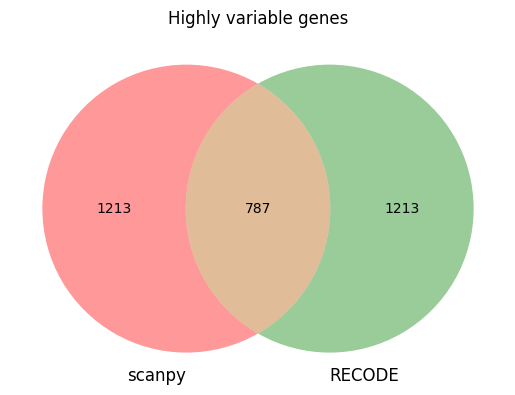

In [14]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
venn2(subsets=(n_top_genes-n_gene_intrsct, n_top_genes-n_gene_intrsct, n_gene_intrsct),set_labels=('scanpy', 'RECODE'))
plt.title("Highly variable genes")
plt.show()

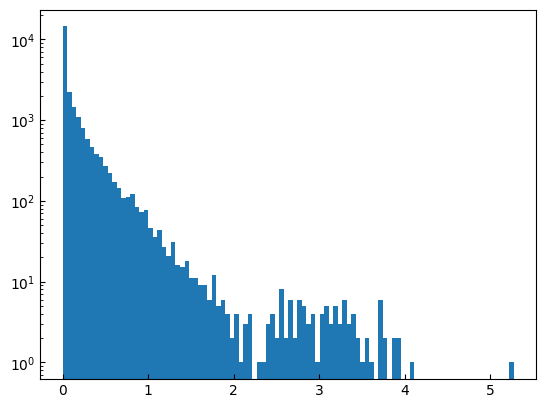

In [15]:
Raw_gene_mean = np.mean(adata.X.toarray(),axis=0)

plt.figure()
plt.hist(Raw_gene_mean,log=True,bins=100);

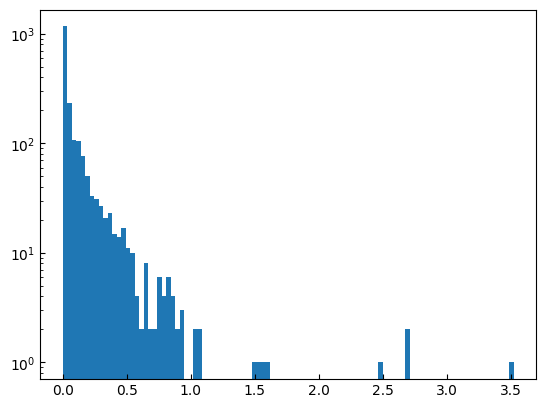

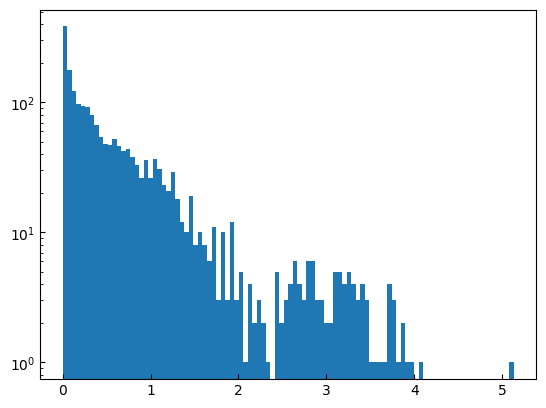

In [16]:
Raw_hvg_mean = np.mean(adata.X.toarray()[:, adata.var.highly_variable],axis=0)
RECODE_hvg_mean = np.mean(adata_RECODE.X[:,adata_RECODE.var["highly_variable_RECODE"]],axis=0)

plt.figure()
plt.hist(Raw_hvg_mean,log=True,bins=100);

plt.figure()
plt.hist(RECODE_hvg_mean,log=True,bins=100);

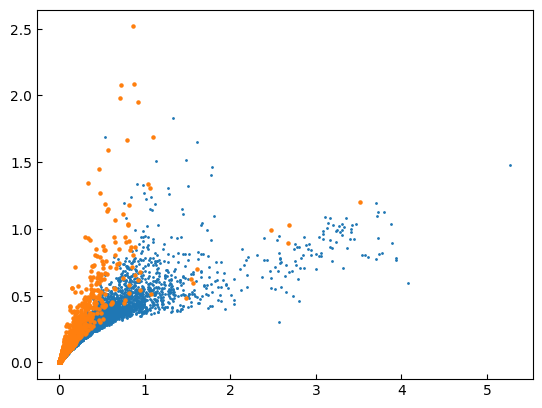

In [17]:
Raw_gene_mean = np.mean(adata.X.toarray(),axis=0)
Raw_gene_var = np.var(adata.X.toarray(),axis=0)

plt.scatter(Raw_gene_mean,Raw_gene_var,s=1)
plt.scatter(Raw_gene_mean[adata.var.highly_variable],Raw_gene_var[adata.var.highly_variable],s=5)

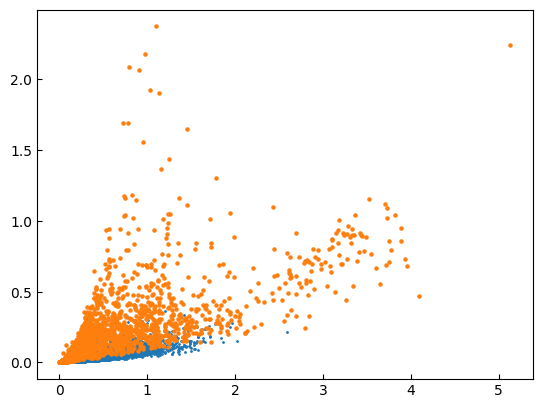

In [18]:
RECODE_gene_mean = np.mean(adata_RECODE.X,axis=0)
RECODE_gene_var = np.var(adata_RECODE.X,axis=0)

plt.scatter(RECODE_gene_mean,RECODE_gene_var,s=1)
plt.scatter(RECODE_gene_mean[adata_RECODE.var.highly_variable_RECODE],RECODE_gene_var[adata_RECODE.var.highly_variable_RECODE],s=5)

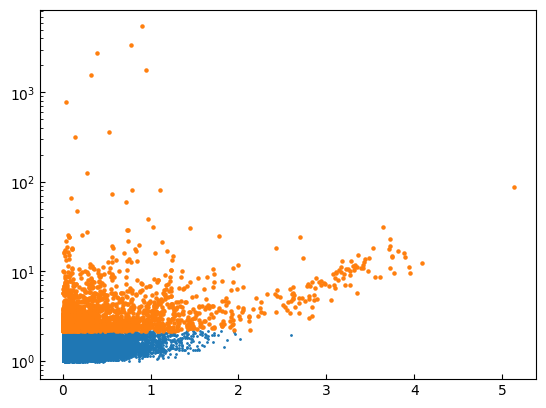

In [19]:


RECODE_gene_mean = np.mean(adata_RECODE.X,axis=0)
RECODE_gene_var = np.var(adata_RECODE.X,axis=0)

plt.scatter(RECODE_gene_mean,adata_RECODE.var.normalized_variance_RECODE.values,s=1)
plt.scatter(RECODE_gene_mean[adata_RECODE.var.highly_variable_RECODE],adata_RECODE.var.normalized_variance_RECODE.values[adata_RECODE.var.highly_variable_RECODE],s=5)
plt.yscale("log")

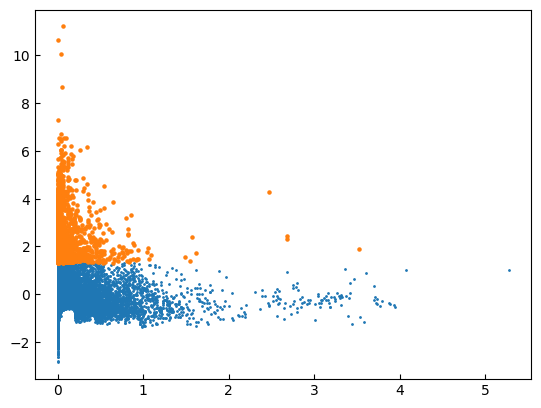

In [20]:
np.sum(adata.var.highly_variable[np.argsort(adata.var.dispersions_norm)[::-1]][:2000])


Raw_gene_mean = np.mean(adata.X.toarray(),axis=0)

plt.scatter(Raw_gene_mean,adata.var.dispersions_norm,s=1)
plt.scatter(Raw_gene_mean[adata.var.highly_variable],adata.var.dispersions_norm[adata.var.highly_variable],s=5)


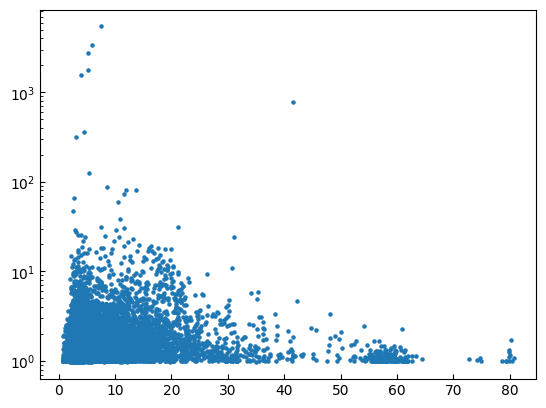

In [24]:
plt.scatter(var_rate,adata_RECODE.var.normalized_variance_RECODE,s=5)
plt.yscale("log")

## PCA

In [25]:
sc.tl.pca(adata, svd_solver='arpack')
sc.tl.pca(adata_RECODE, svd_solver='arpack')

In [58]:
n_neighbors=15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=None)
sc.tl.umap(adata)

In [27]:
sc.pp.neighbors(adata_RECODE, n_neighbors=n_neighbors, n_pcs=0)
sc.tl.umap(adata_RECODE)

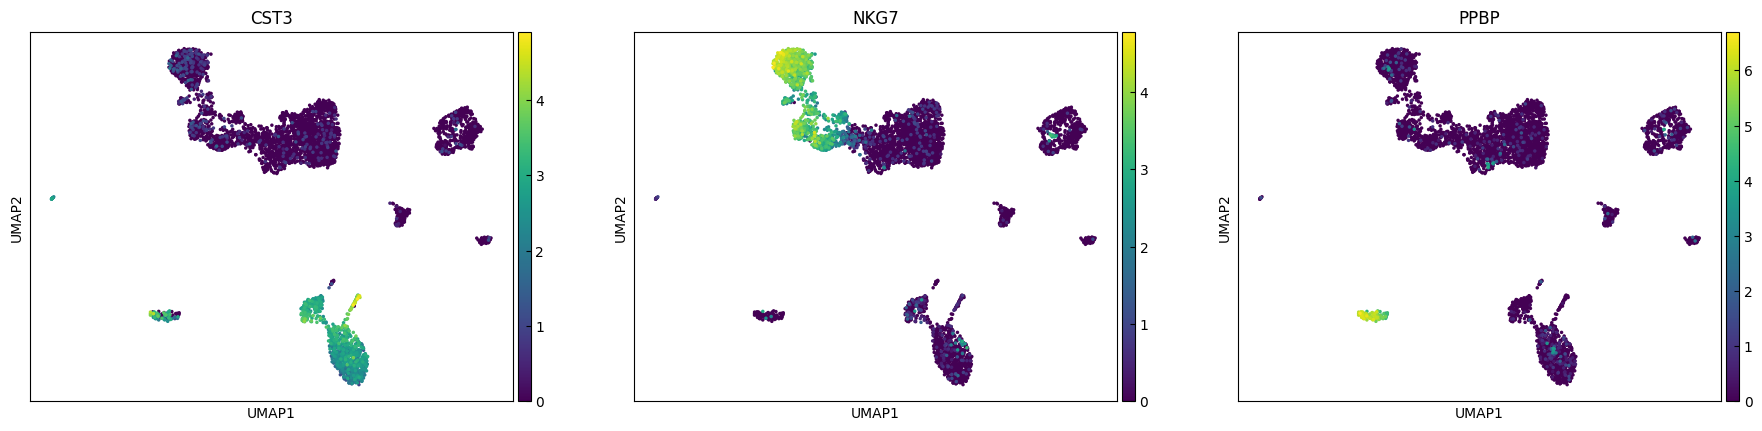

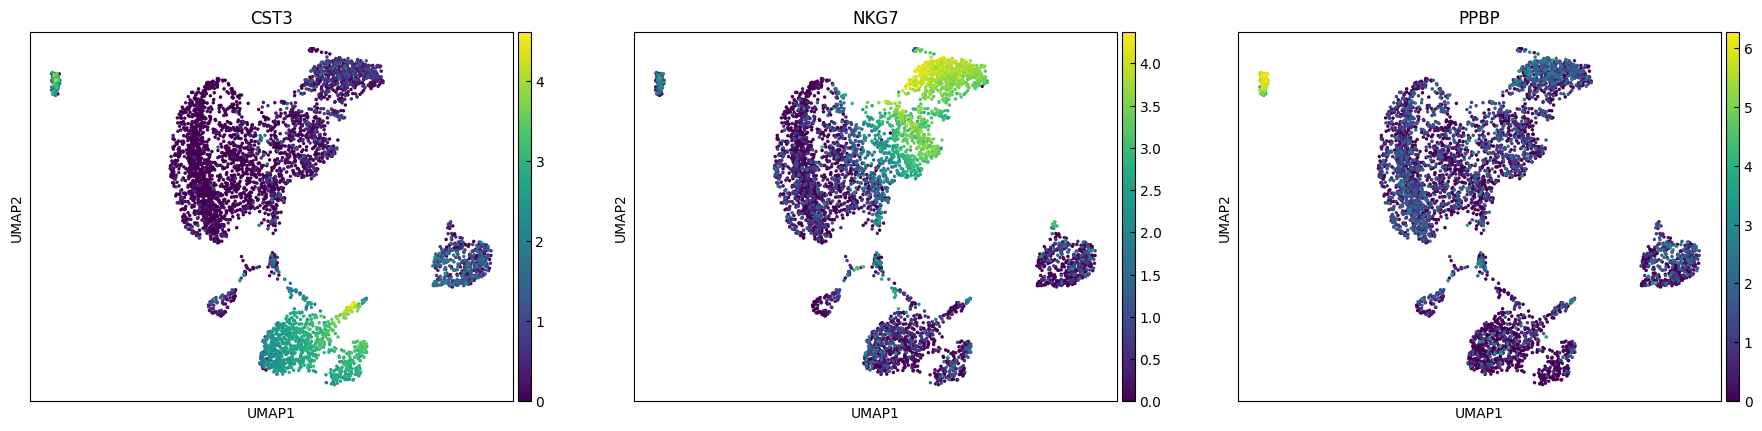

In [28]:
key_genes = ['CST3', 'NKG7', 'PPBP']
sc.pl.umap(adata, color=key_genes)
sc.pl.umap(adata_RECODE, color=key_genes)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


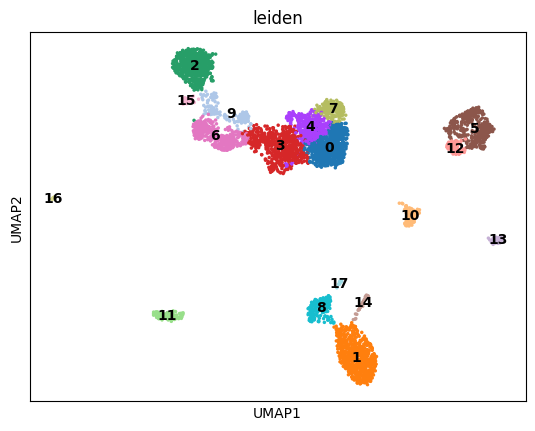

In [29]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'],legend_loc="on data")

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


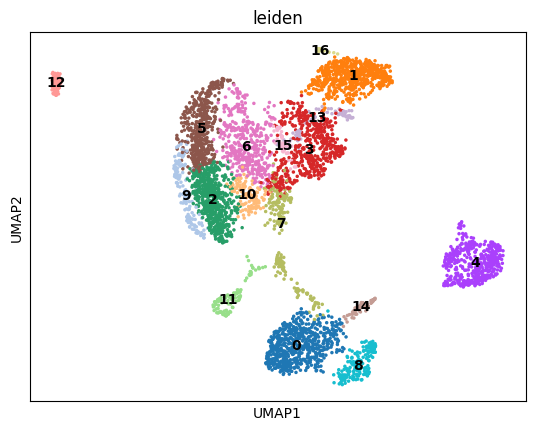

In [30]:
sc.tl.leiden(adata_RECODE,resolution=1)
sc.pl.umap(adata_RECODE, color=['leiden'],legend_loc="on data")

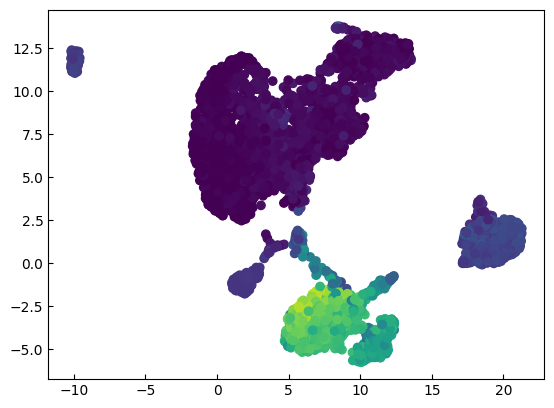

In [31]:
idx_var_rate = np.argsort(var_rate)[::-1]

i = 0

plot_data = adata_RECODE.obsm["X_umap"]
color_data = adata_RECODE.X[:,idx_var_rate[0]]
plt.scatter(plot_data[:,0],plot_data[:,1],c=color_data)

## Find marker genes

In [59]:
import sklearn.neighbors

data = adata_RECODE.X
knn_model = sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn_model.fit(data)
distances, indices = knn_model.kneighbors(data)

(array([2.050e+02, 3.342e+03, 4.339e+03, 3.229e+03, 2.221e+03, 1.582e+03,
        1.164e+03, 9.840e+02, 8.020e+02, 9.630e+02, 1.384e+03, 1.324e+03,
        2.820e+02, 2.150e+02, 1.860e+02, 1.430e+02, 1.390e+02, 1.050e+02,
        1.210e+02, 1.050e+02, 8.100e+01, 6.600e+01, 6.600e+01, 4.300e+01,
        4.200e+01, 4.200e+01, 2.800e+01, 3.500e+01, 1.700e+01, 1.800e+01,
        1.600e+01, 2.100e+01, 2.200e+01, 1.300e+01, 1.800e+01, 1.500e+01,
        1.500e+01, 9.000e+00, 1.300e+01, 9.000e+00, 9.000e+00, 1.100e+01,
        5.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 6.000e+00, 6.000e+00,
        8.000e+00, 2.400e+01, 2.700e+01, 1.500e+01, 1.600e+01, 3.600e+01,
        2.000e+01, 1.100e+01, 1.200e+01, 1.600e+01, 1.200e+01, 9.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+0

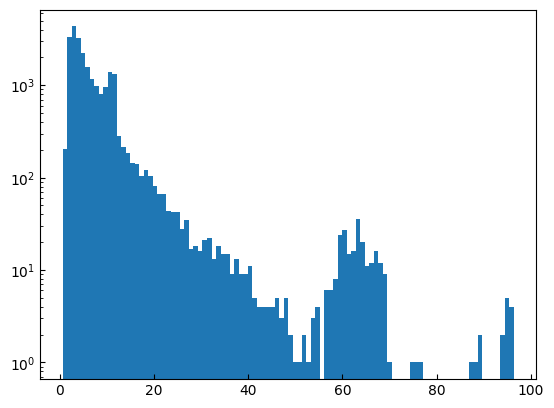

In [76]:
global_var = np.var(data,axis=0)
local_var = np.mean(np.var(data[indices],axis=1),axis=0)
var_rate = np.nan_to_num(global_var/local_var)

plt.hist(var_rate,log=True,bins=100)

In [53]:
var_percentile = 80
to_var_percentile = np.percentile(adata_RECODE.var.normalized_variance_RECODE,var_percentile)
idx_var_percentile = adata_RECODE.var.normalized_variance_RECODE > to_var_percentile


idx_var_rate = np.argsort(var_rate[idx_var_percentile])[::-1]
marker_genes = adata_RECODE.var.index[idx_var_percentile][idx_var_rate]

len(marker_genes)

4746

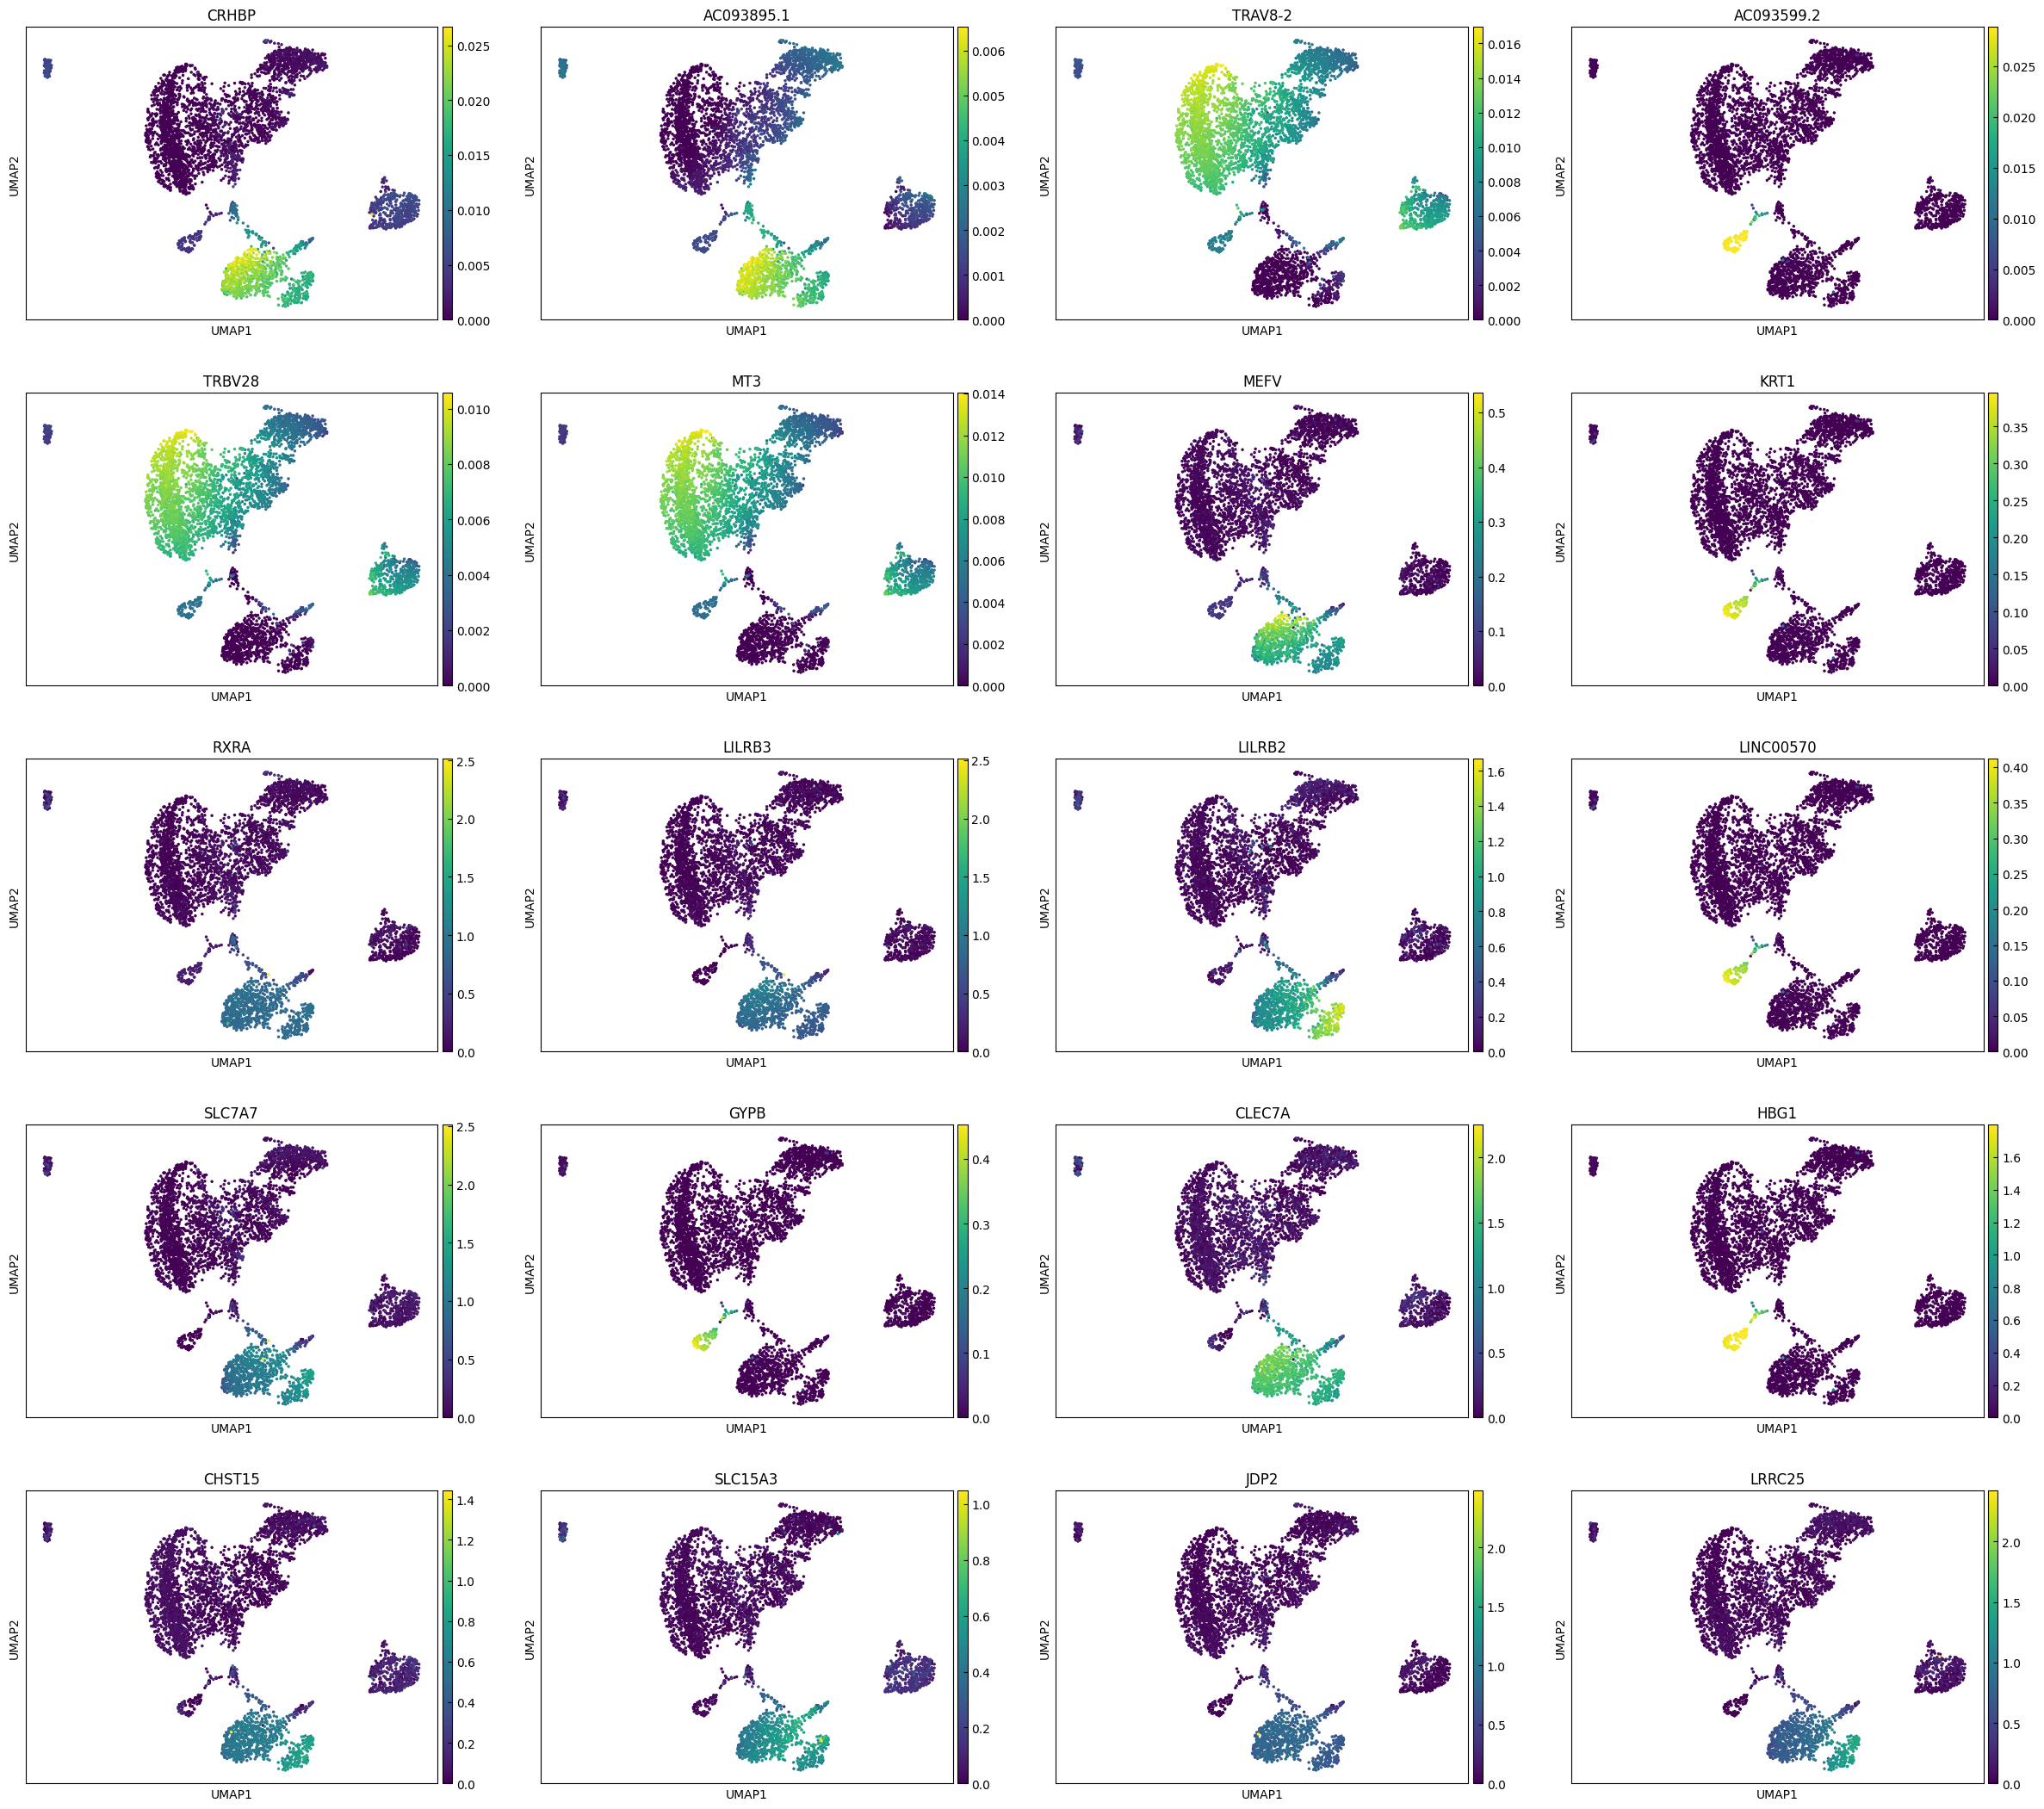

4746

In [54]:
key_genes = marker_genes[:20]
# sc.pl.umap(adata, color=key_genes)
sc.pl.umap(adata_RECODE, color=key_genes)
len(marker_genes)

In [55]:
n_genes = 1000
import umap

idx_marker_genes = np.isin(adata.var.index,marker_genes[:n_genes])
X_umap = umap.UMAP(n_components=2,random_state=0,n_neighbors=n_neighbors).fit_transform(adata_RECODE.X[:,idx_marker_genes])
len(marker_genes)

4746

In [56]:
marker_genes

Index(['CRHBP', 'AC093895.1', 'TRAV8-2', 'AC093599.2', 'TRBV28', 'MT3', 'MEFV',
       'KRT1', 'RXRA', 'LILRB3',
       ...
       'SELENOP', 'MEIS2', 'FSIP2-AS1', 'AC007563.2', 'HESX1', 'AC004817.5',
       'AL132857.1', 'AP000350.5', 'AADACL2-AS1', 'HEPH'],
      dtype='object', length=4746)

In [66]:
np.arange(0,n_plots,n_cols)

array([ 0,  4,  8, 12, 16])

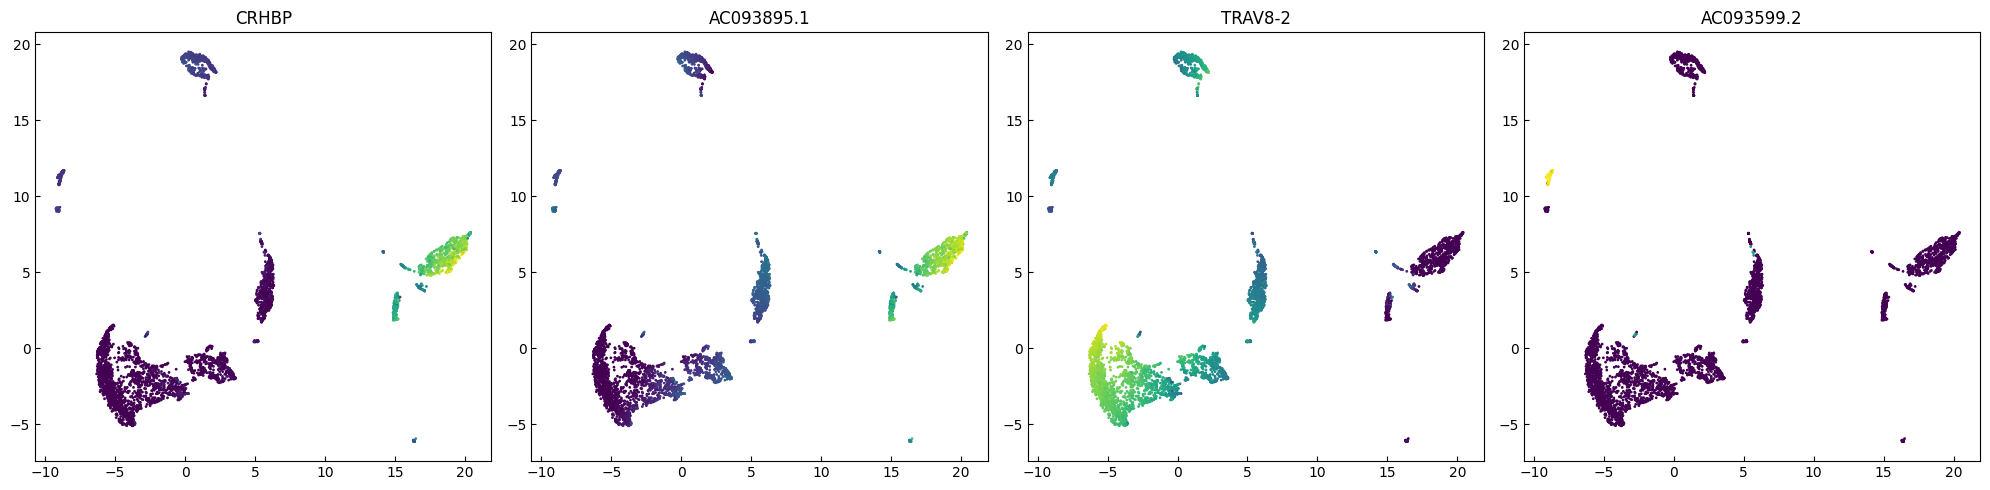

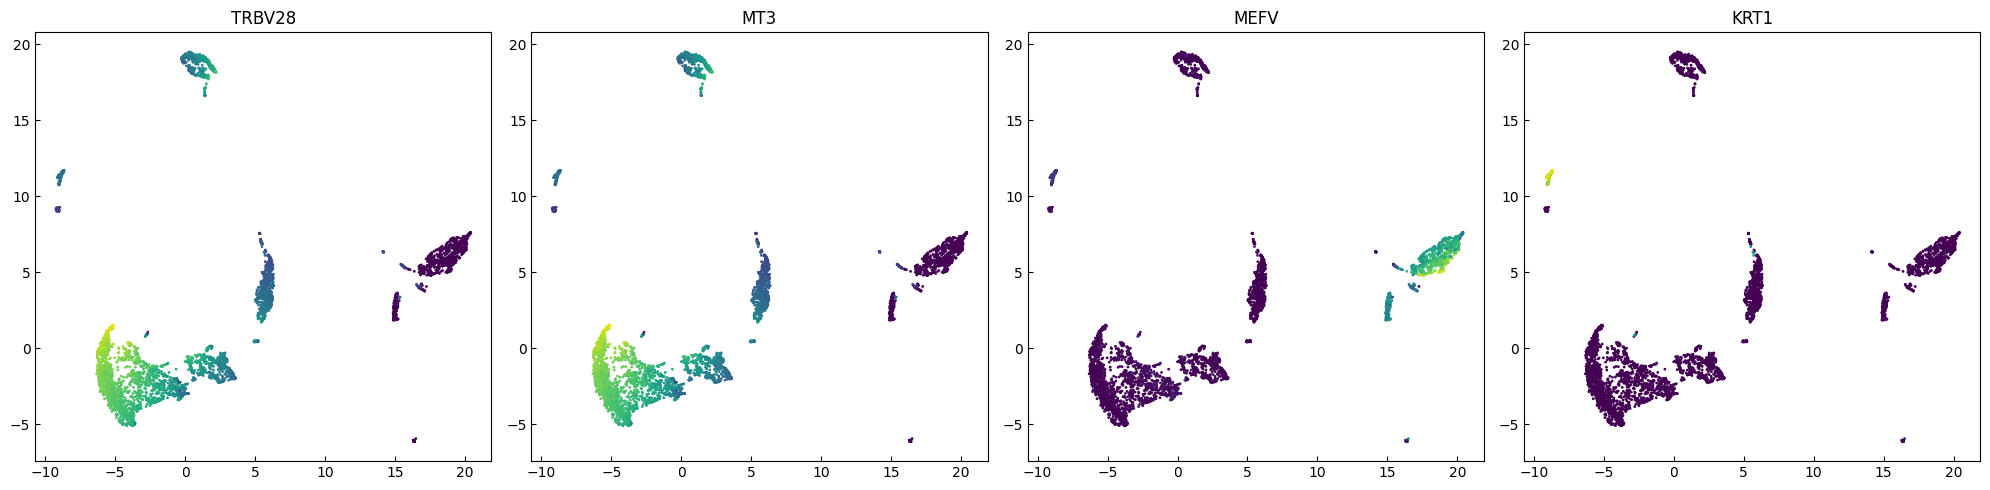

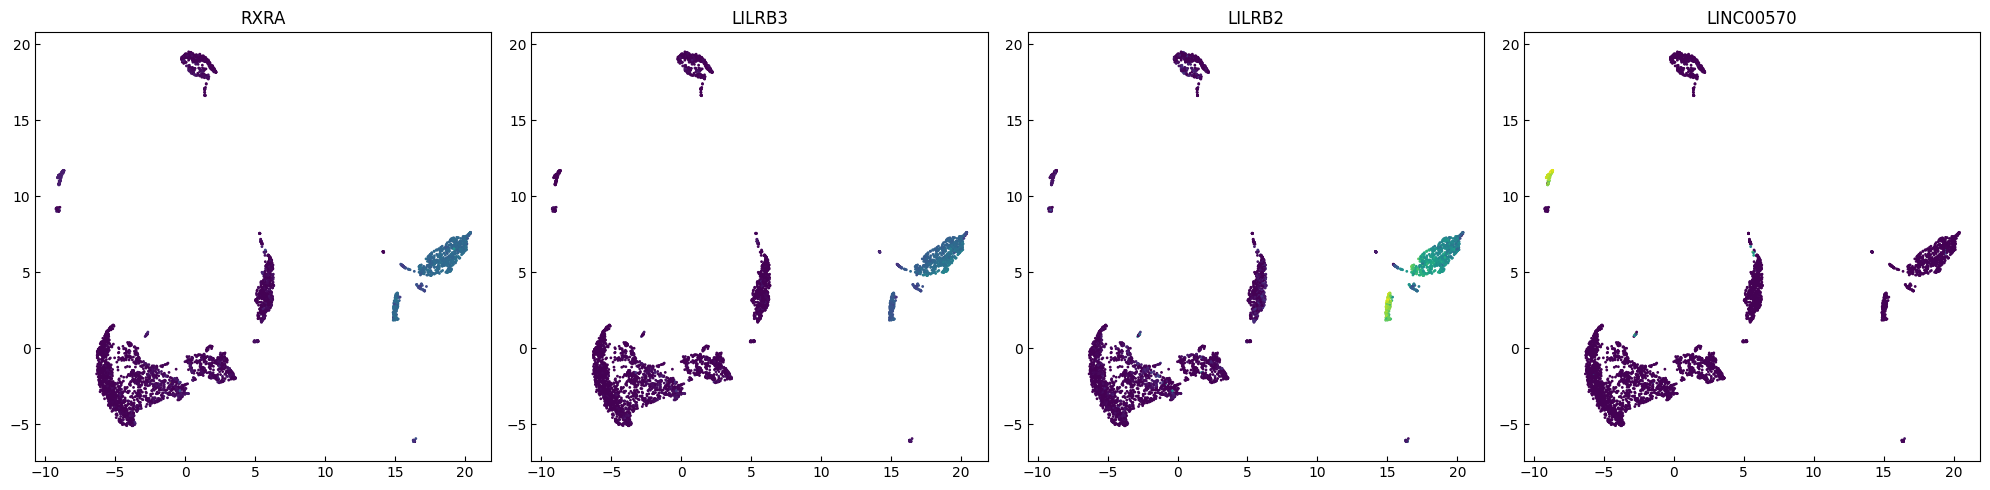

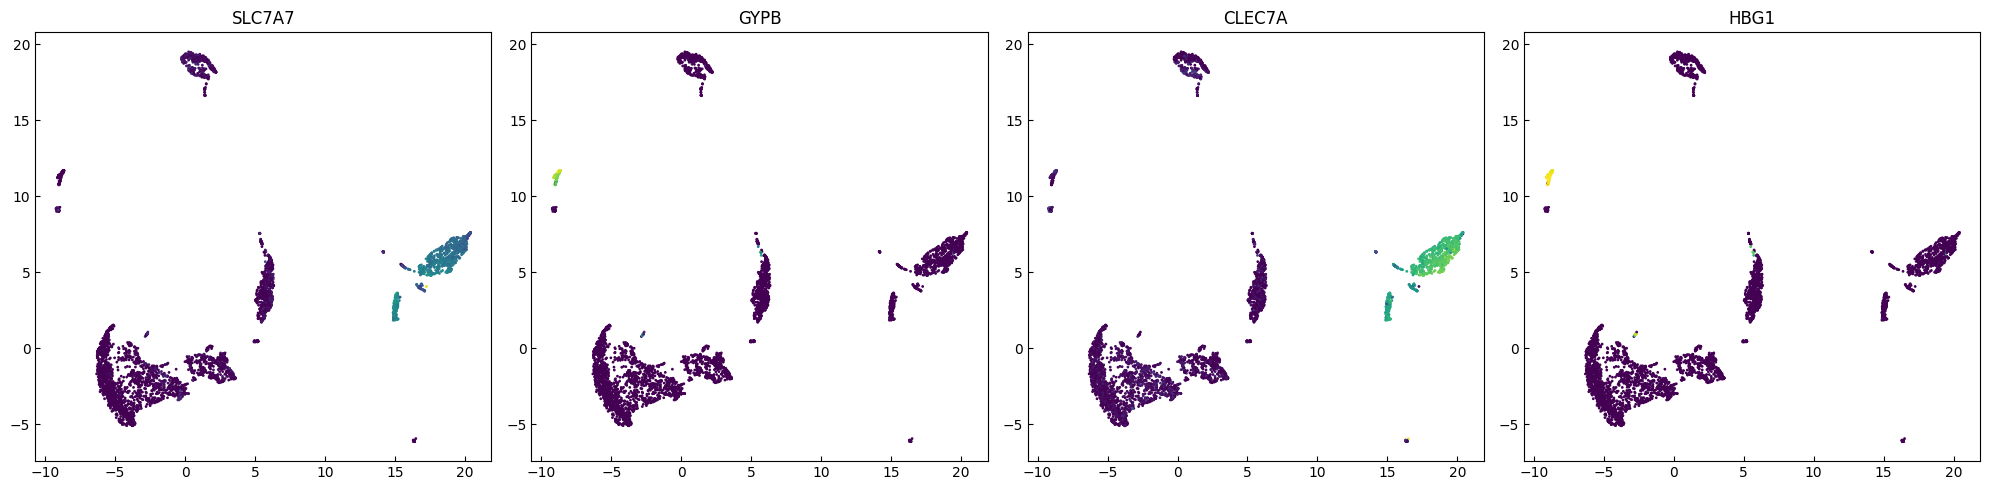

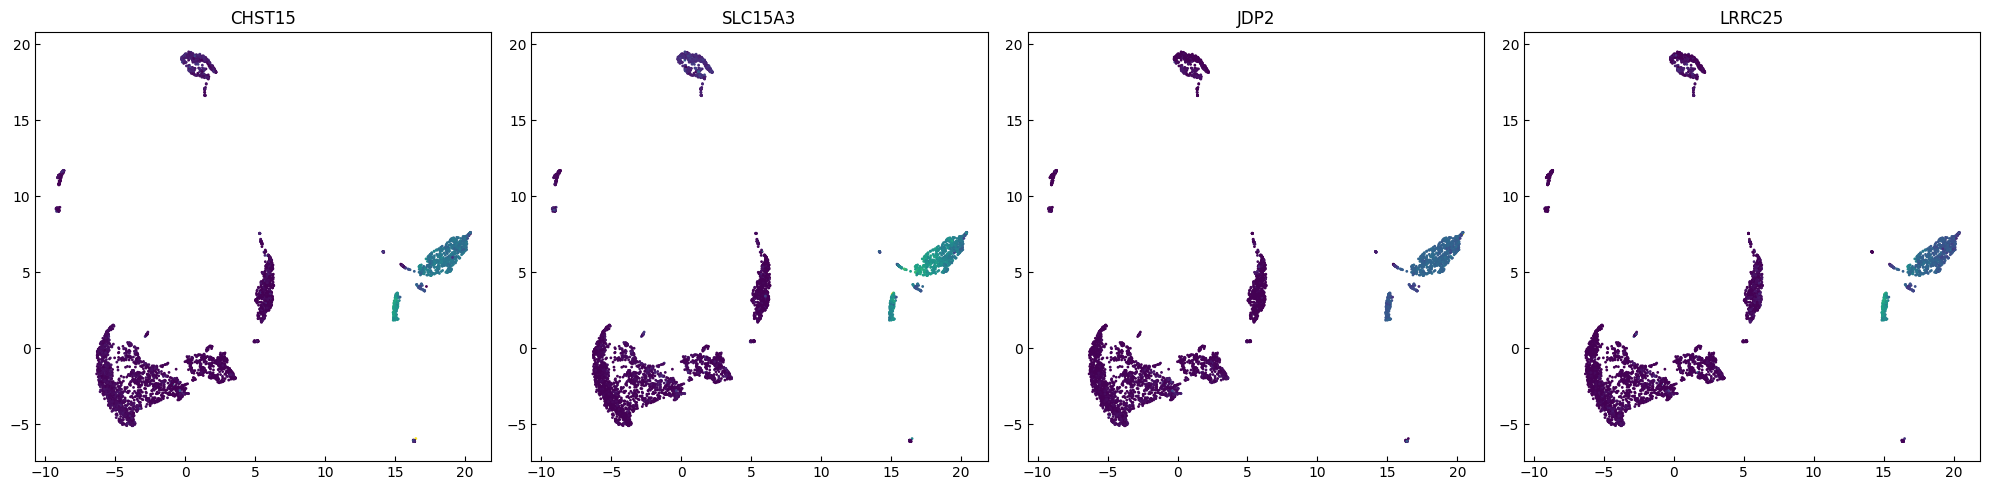

In [75]:
plot_data = X_umap
color_data = adata_RECODE.X
n_cols = 4
n_plots = 20

for i in np.arange(0,n_plots,n_cols):
    fig,ax = plt.subplots(1,n_cols,figsize=(5*n_cols,5),tight_layout=True)
    for j in range(n_cols):
        if i+j >= n_plots:
            break
        ax[j].scatter(plot_data[:,0],plot_data[:,1],c=color_data[:,adata_RECODE.var.index==marker_genes[i+j]],s=1)
        ax[j].set_title(marker_genes[i+j])

In [36]:
if scipy.sparse.issparse(adata.X):
    adata.X = adata.X.toarray()
clusters = adata.obs['leiden']
cluster_set = np.unique(clusters)
adata.uns["cluster_center"] = pd.DataFrame([np.mean(adata.X[clusters==c_],axis=0) for c_ in cluster_set],columns=adata.var.index,index=cluster_set)

clusters = adata_RECODE.obs['leiden']
cluster_set = np.unique(clusters)
adata_RECODE.uns["cluster_center"] = pd.DataFrame([np.mean(adata_RECODE.X[clusters==c_],axis=0) for c_ in cluster_set],columns=adata_RECODE.var.index,index=cluster_set)

In [37]:
pd_ = pd.concat([adata.uns["cluster_center"],adata_RECODE.uns["cluster_center"]])
pd_corr = pd_.T.corr()

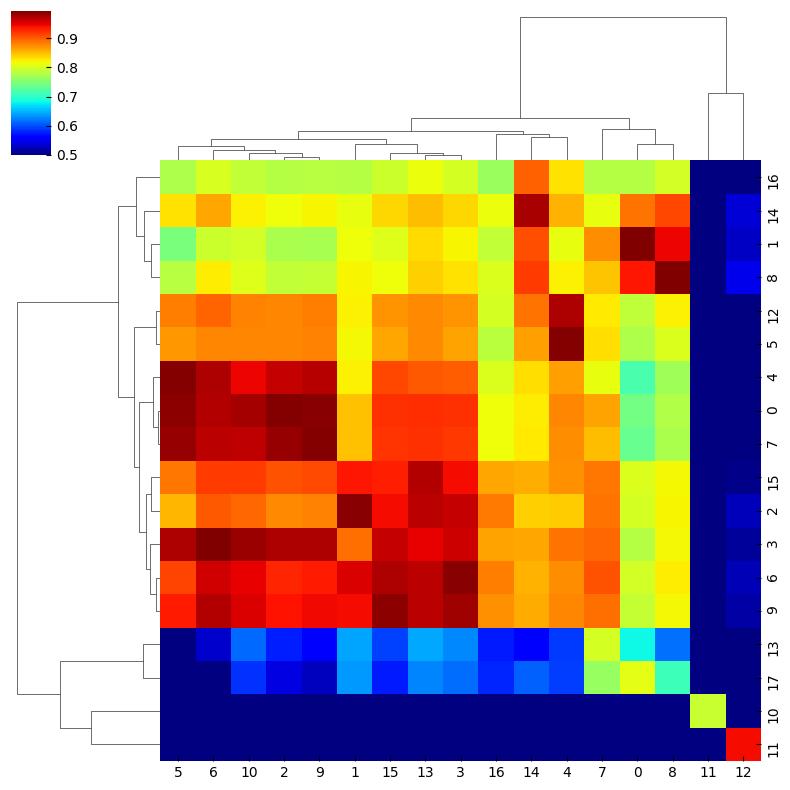

In [38]:
import seaborn as sns
sns.clustermap(pd_corr[:adata.uns["cluster_center"].shape[0]].T[adata.uns["cluster_center"].shape[0]:].T,cmap="jet",vmin=0.5,figsize=(8,8))


C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


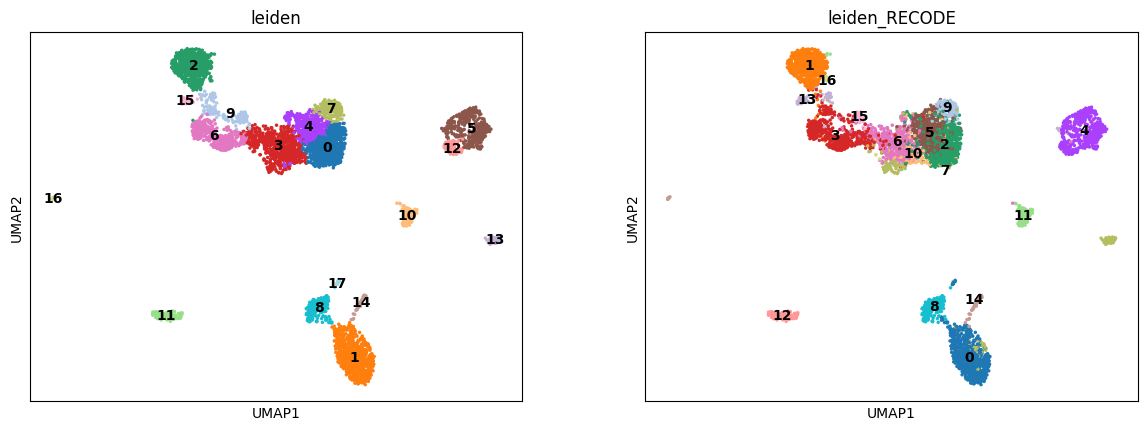

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


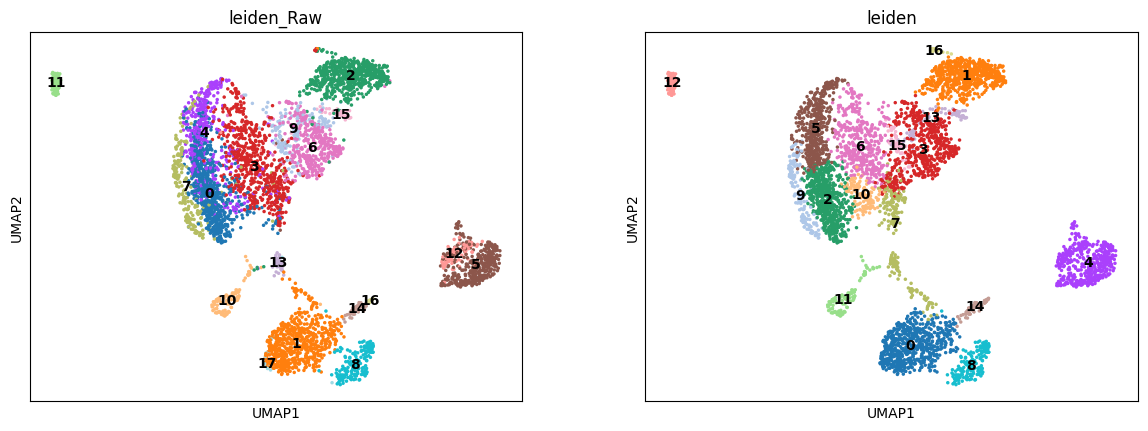

In [39]:
adata.obs['leiden_RECODE'] = adata_RECODE.obs['leiden']
sc.pl.umap(adata, color=['leiden','leiden_RECODE'],legend_loc="on data")


adata_RECODE.obs['leiden_Raw'] = adata.obs['leiden']
sc.pl.umap(adata_RECODE, color=['leiden_Raw','leiden'],legend_loc="on data")

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


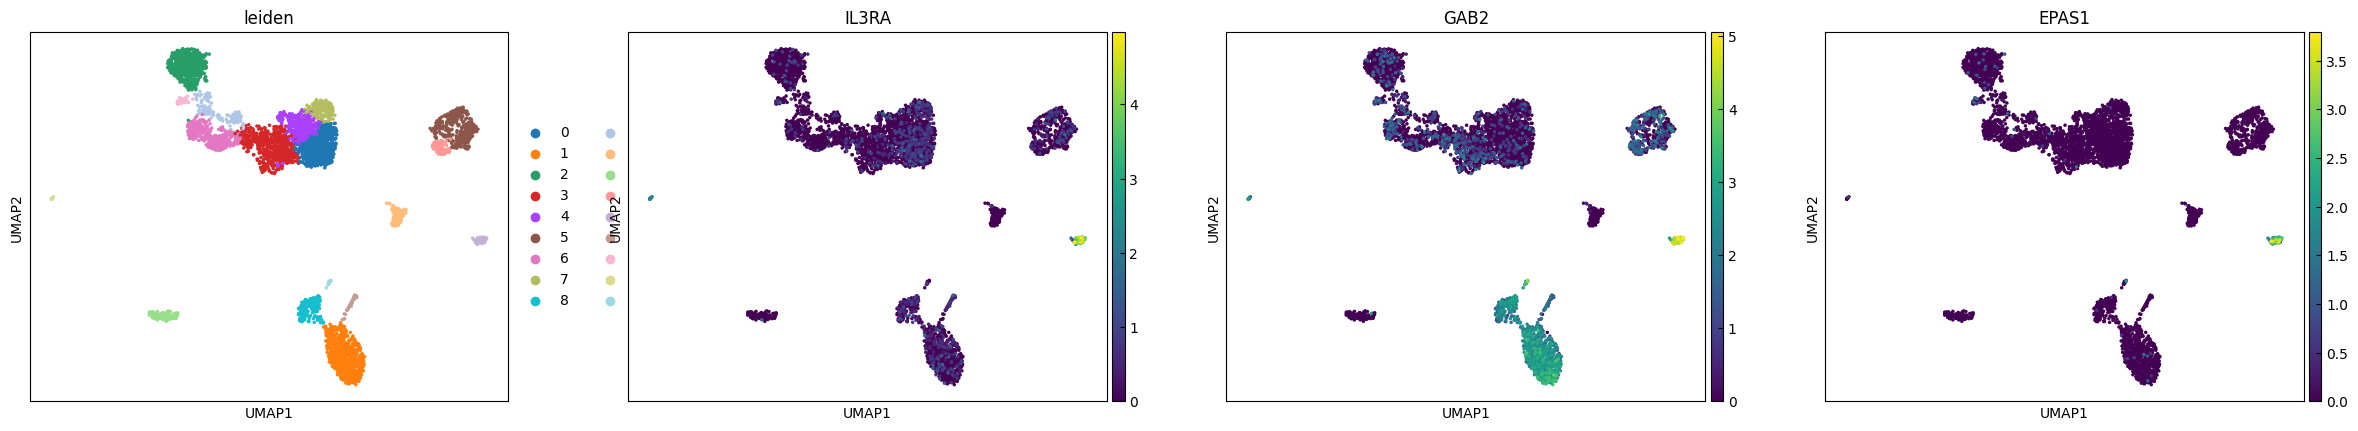

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


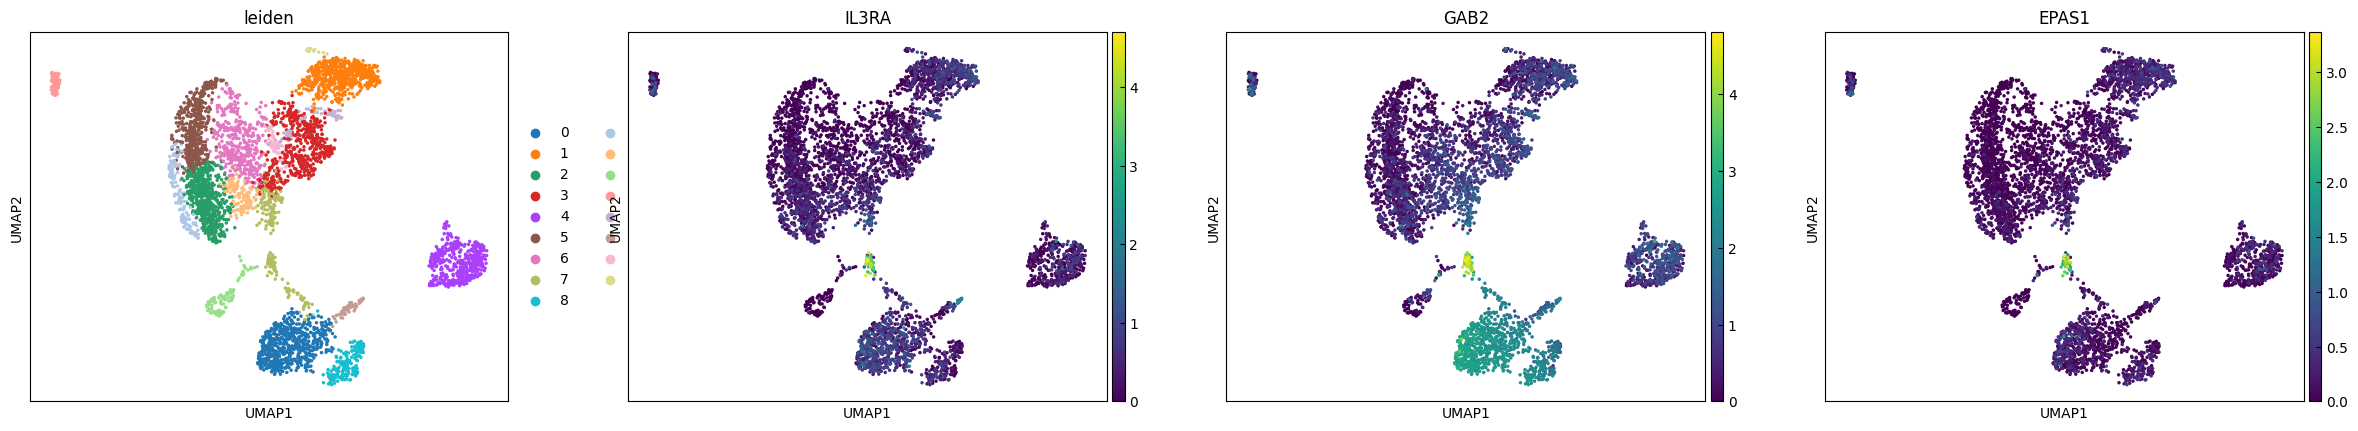

In [40]:
sc.pl.umap(adata, color=['leiden','IL3RA','GAB2',"EPAS1"])
sc.pl.umap(adata_RECODE, color=['leiden','IL3RA','GAB2',"EPAS1"])

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.tl.rank_genes_groups(adata_RECODE, 'leiden', method='t-test')

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
cluster_nmbr = 7
for i in range(25):
    print(adata_RECODE.uns["rank_genes_groups"]["names"][i][cluster_nmbr])

GPER1
LINC01924
MAP3K5
FAM72B
AC140125.3
CHST11
SMCHD1
PHIP
ACOX2
PAG1
PELI1
CDC42SE2
PCNX1
ARID4B
COP1
HERC1
FBXW7
MAP3K1
CPA6
GLIPR1L1
ANGPTL6
GAREM2
AKT3-IT1
USP15
AC005014.4


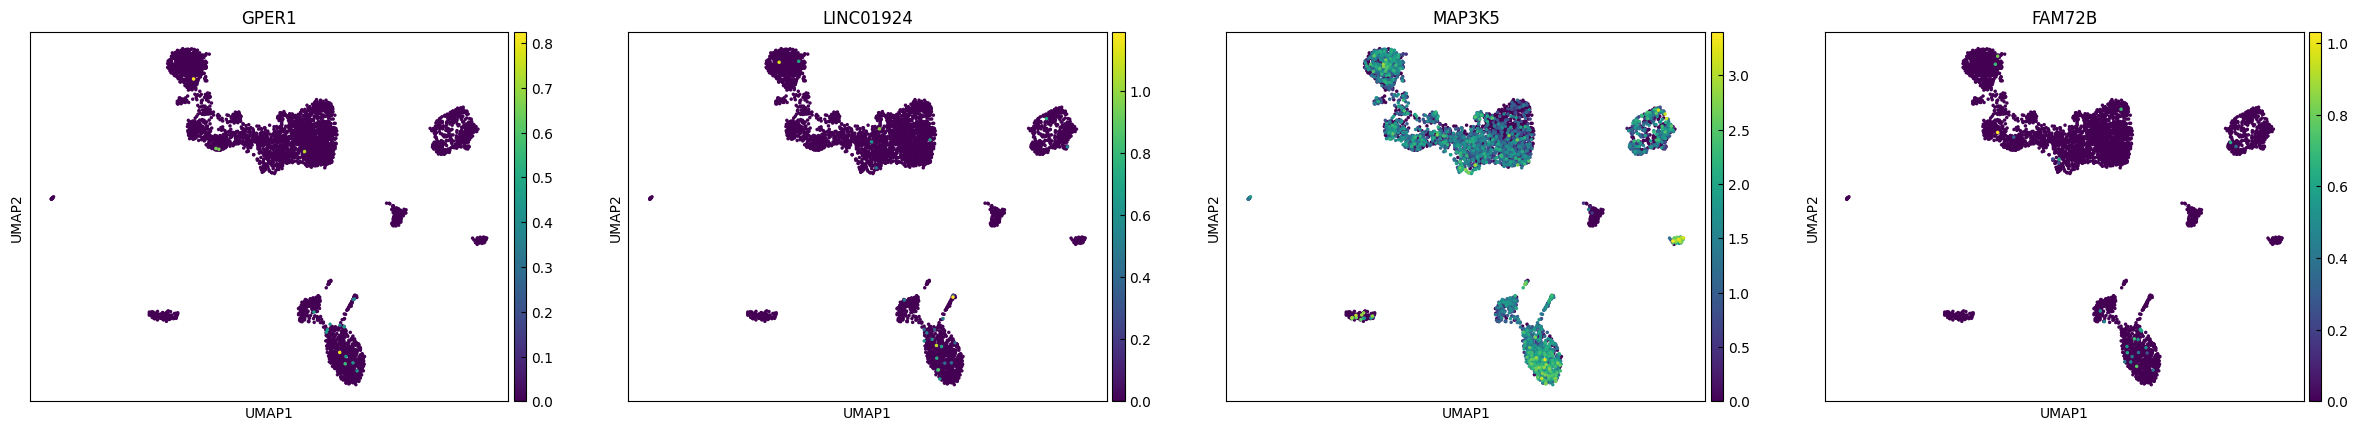

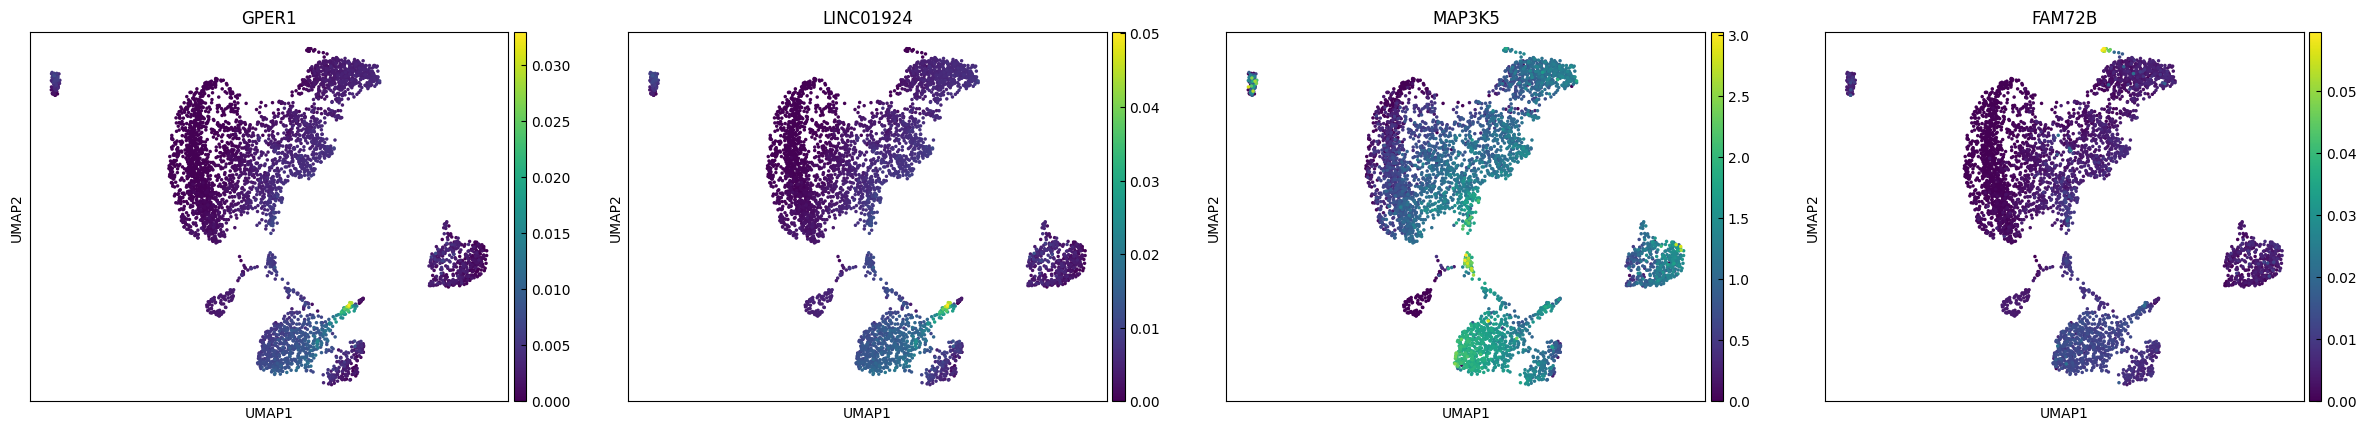

In [43]:
key_genes_ = [adata_RECODE.uns["rank_genes_groups"]["names"][i][cluster_nmbr] for i in range(4)]
sc.pl.umap(adata, color=key_genes_)
sc.pl.umap(adata_RECODE, color=key_genes_)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


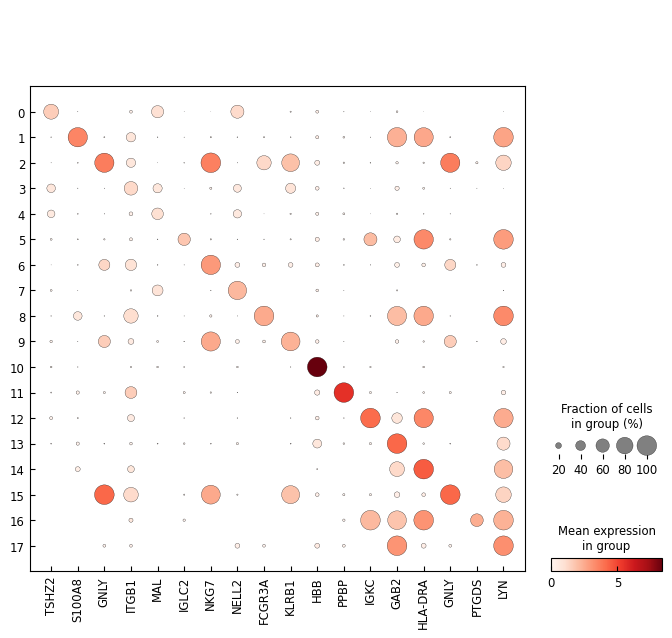

In [44]:
marker_genes = (list(adata.uns["rank_genes_groups"]["names"][0]))
sc.pl.dotplot(adata, marker_genes, groupby='leiden',expression_cutoff=1)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


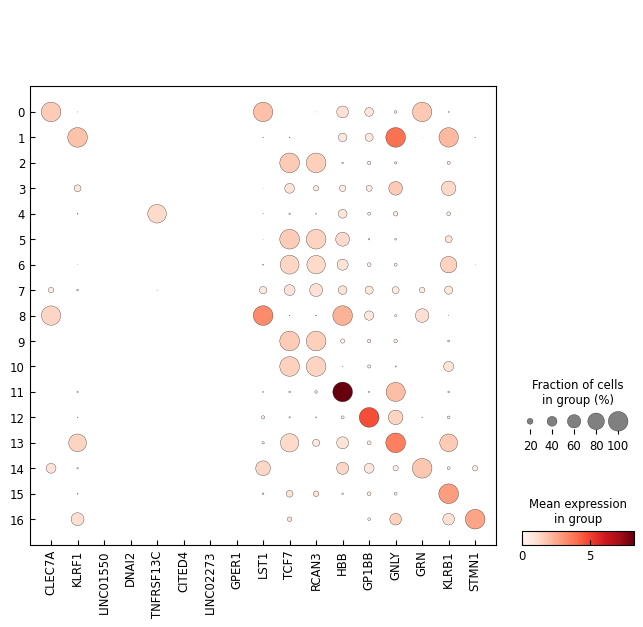

In [45]:
marker_genes_RECODE = (list(adata_RECODE.uns["rank_genes_groups"]["names"][0]))
sc.pl.dotplot(adata_RECODE, marker_genes_RECODE, groupby='leiden',expression_cutoff=1)

regev_lab_cell_cycle_genes.txt is abailable [here](https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt)

In [46]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [47]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.tl.score_genes_cell_cycle(adata_RECODE, s_genes=s_genes, g2m_genes=g2m_genes)

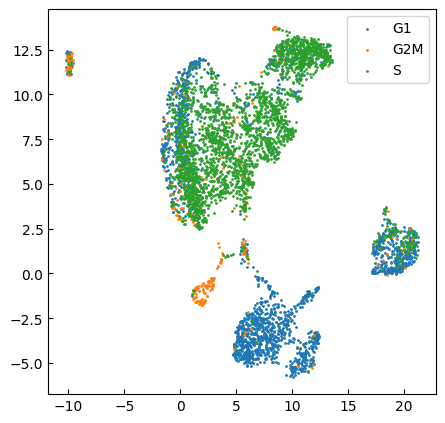

In [48]:
ps = 1
clusters = adata_RECODE.obs.phase.values
plot_data = adata_RECODE.obsm["X_umap"]
fig = plt.figure(figsize=(5,5))
for c_ in np.unique(clusters):
    idx_ = clusters == c_
    plt.scatter(plot_data[idx_,0],plot_data[idx_,1],s=ps,label=c_)
plt.legend()

In [49]:
adata.X.toarray()[:,adata.var.index==marker_genes[i]]

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [ ]:
i = 0
for g_ in marker_genes:
    plt.figure(figsize=(5,5))
    plt.scatter(adata.X.toarray()[:,adata.var.index==g_],adata_RECODE.X[:,adata.var.index==g_],s=1)

In [ ]:
adata.obs["leiden"]

In [ ]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5
import seaborn as sns

def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    # cell_type = "_".join(group_key.split("_")[1:])
    cell_type = group_key
    result = sc.get.rank_genes_groups_df(adata, group=cell_type).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

sc.tl.rank_genes_groups(adata, groupby="leiden")
for i in range(5):
    volcano_plot(adata, group_key=str(i), group_name="leiden")

sc.tl.rank_genes_groups(adata_RECODE, groupby="leiden")
for i in range(5):
    volcano_plot(adata_RECODE, group_key=str(i), group_name="leiden")

In [ ]:
import matplotlib.pyplot as plt


size_factor = 1e5
alpha = 0.2
plot_data = [np.log(size_factor*adata.X.toarray().T/np.sum(adata.X.toarray(),axis=1)+1).T,
            np.log(size_factor*adata_RECODE.layers['RECODE'].T/np.sum(adata_RECODE.layers['RECODE'],axis=1)+1).T]
names = ['Original','RECODE']

def plot_scatter(plot_data,names,genes):
    n_ax = len(plot_data)
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_ax):
        ax[i].scatter(plot_data[i][:,adata.var.index==genes[0]], plot_data[i][:,adata.var.index==genes[1]], alpha=alpha,zorder=10,color="gray")
        ax[i].set_xlabel(genes[0])
        ax[i].set_ylabel(genes[1])
        ax[i].set_title(names[i])
        ax[i].grid(ls='--',color='gray',zorder=0)

plot_scatter(plot_data,names,genes = ['CD19','CD3D'])
plot_scatter(plot_data,names,genes = ['CD4','CD8A'])